# 1:Mesh for a brak disc
This part is from Jørgen S. Dokken blog: Mesh generation use gmsh API 
https://jsdokken.com/src/tutorial_gmsh.html



In [1]:
import gmsh
import sys
import math
import os
import numpy as np

gmsh.initialize()
# all the unit is mm

# z1, z2, z3 is the height of brake disc, rubbing elemetn, pad lining in Z direction
# rd_outer, rd_inner is for brake disc, rp_outer, rp_inner is for brake pad radiu. r_rub is for rubbing elements
# angle1 is brake pad in degree system, angle is in radians system
element_min = 3
element_max = 15

z1, z2, z3 = 20, 33, 30
rd_o, rd_i = 320, 175 
r_rub = 18.8
rp_o, rp_i = 303, 178

angle1 = 80
angle = angle1 / 360 * 2 * math.pi

# gmsh.model.occ.addCylinder
# x (double), y (double), z (double), dx (double), dy (double), dz (double),
# r (double), tag = -1 (integer), angle = 2*pi (double)

# brake disc
outer_disc  = gmsh.model.occ.addCylinder(0,0,0,  0, 0, z1,  rd_o)
inner_disc  = gmsh.model.occ.addCylinder(0,0,0,  0, 0, z1,  rd_i)
disk = gmsh.model.occ.cut([(3, outer_disc)], [(3, inner_disc)])

# rubbing elements
import sys
sys.path.append('/home/yanjun/Documents/FEniCSx/Tutorial/Mesh/')
from rub_co import get_rub_coordinate
x_co, y_co = get_rub_coordinate()
    
rub_list = []
for i, (x, y) in enumerate(zip(x_co, y_co), start=1):
    var_name = f"rub{i}"
    tag = gmsh.model.occ.addCylinder(x, y, z1, 0, 0, z2, r_rub)
    globals()[var_name] = tag
    rub_list.append(globals()[var_name])
    

# brake pad, in [(3, )],3 means dimension, cut the common place, out - inner
outer_pad  = gmsh.model.occ.addCylinder(0,0,z1+z2,  0, 0, z3,  rp_o, 50, angle)
inner_pad  = gmsh.model.occ.addCylinder(0,0,z1+z2,  0, 0, z3,  rp_i, 51, angle)
pad = gmsh.model.occ.cut([(3, outer_pad)], [(3, inner_pad)]) 

# Initialize the shell with the first rub
rub_list = [rub1, rub2, rub3, rub4, rub5, rub6, rub7, 
            rub8, rub9, rub10, rub11, rub12, rub13, rub14, rub15, rub16, rub17, rub18]
shell = gmsh.model.occ.fuse([(3, outer_pad)], [(3, rub_list[0])], 70)
for i in range(len(rub_list) - 1):
    shell = gmsh.model.occ.fuse([(3, 70 + i)], [(3, rub_list[i + 1])], 71 + i)
gmsh.model.occ.synchronize()

# Add physical group, this step should after synchronize to make sure success
# https://gitlab.onelab.info/gmsh/gmsh/blob/master/tutorials/python/t1.py#L115

# Volumes: 31,32 brake disc and pad.
volumes = gmsh.model.occ.getEntities(dim = 3)
gmsh.model.addPhysicalGroup(3, volumes[0], 31)
gmsh.model.addPhysicalGroup(3, volumes[1], 32)

# Surfaces: brake disc, 21 = friction surface
surfaces = gmsh.model.occ.getEntities(dim = 2)
gmsh.model.addPhysicalGroup(2, (2,6), 21)

# Rubbing elements, from 1 to 19, here 32 is the origin name tag of rub surface(32-49)
rublist = list(range(32,50))
for rub in rublist:
   gmsh.model.addPhysicalGroup(2, (2, rub), rub-31)

gmsh.model.occ.synchronize()

#
gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 2)
  

# for the rubbing elements, P13 of UIC 541-3
# Sinter material, 200 cm2, 18 rubbing elemets, r = 1.88 cm
# Mesh size
gmsh.option.setNumber("Mesh.MeshSizeMin", element_min)
gmsh.option.setNumber("Mesh.MeshSizeMax", element_max)

# Mesh file save
gmsh.model.mesh.generate(3)
gmsh.write("disc.msh")

# Launch the GUI to see the results:
if '-nopopup' not in sys.argv:
    gmsh.fltk.run()
gmsh.finalize()


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 4 (Circle)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Circle)
Info    : [ 10%] Meshing curve 7 (Circle)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Circle)
Info    : [ 10%] Meshing curve 10 (Circle)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Circle)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Circle)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Circle)
Info    : [ 30%] Meshing curve 21 (Circle)
Info    : [ 30%] Meshing curve 22 (Circle)
Info    : [ 30%] Meshing curve 23 (Circle)
Info    : [ 30%] Meshing curve 24 (Circle)
Info    : [ 30%] Meshing curve 25 (Circle)
Info    : [ 40%] Meshing curve 26 (Circle)
Info    : [

Info    : Done refining mesh (Wall 0.121736s, CPU 0.120369s)
Info    : 65453 nodes 75180 elements
Info    : Writing 'disc.msh'...
Info    : Done writing 'disc.msh'


X_ChangeProperty: BadValue (integer parameter out of range for operation) 0x0


-------------------------------------------------------
Version       : 4.12.2
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240122
Build host    : f6315eb856a7
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack LinuxJoystick MathEx[contrib] Mesh Metis[contrib] Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.9
OCC version   : 7.7.2
Packaged by   : conda
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


Error   : Unable to open file ''


Info    : Appending visibility info to ''...
Info    : Done appending visibility info


In [2]:
print('Surfaces is', surfaces)
print('Volumes is', volumes)

Surfaces is [(2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (2, 23), (2, 24), (2, 25), (2, 26), (2, 27), (2, 28), (2, 29), (2, 30), (2, 31), (2, 32), (2, 33), (2, 34), (2, 35), (2, 36), (2, 37), (2, 38), (2, 39), (2, 40), (2, 41), (2, 42), (2, 43), (2, 44), (2, 45), (2, 46), (2, 47), (2, 48), (2, 49)]
Volumes is [(3, 1), (3, 87)]


# 2: Mesh plot

THis part is from FEniCSx tutorial: Plotting the mesh using pyvista

https://jsdokken.com/dolfinx-tutorial/chapter1/fundamentals_code.html

Info    : Reading 'disc.msh'...
Info    : 168 entities
Info    : 65453 nodes
Info    : 56793 elements
Info    : Done reading 'disc.msh'


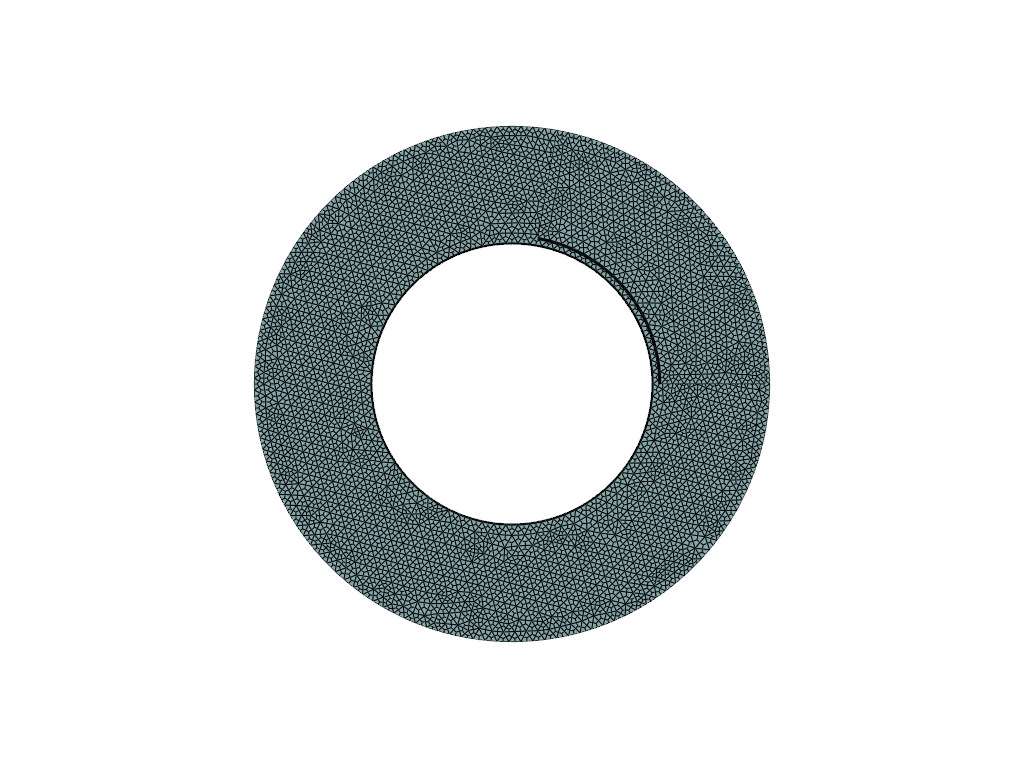

In [3]:
from dolfinx.io import gmshio
from mpi4py import MPI
import pyvista
from dolfinx import plot

# try a 3d mesh from gmsh, it works
domain, cell_markers, facet_markers = gmshio.read_from_msh("disc.msh", MPI.COMM_WORLD, 0, gdim=3)
gdim = 3
tdim = gdim -1 
pyvista.start_xvfb()
# below gdim change to tdim is plot for 2D
topology, cell_types, geometry = plot.vtk_mesh(domain, gdim)

grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

plotter.show()